# Binary Classification of User Reviews on Electric Motorcycles

---

_**Predicting whether a website user review of an EMO electric motorcycle was from an owner or a non-owner**_

---


# Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Validation](#Data-Validation)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Objective Revisited](#Objective-Revisited)
1. [Baseline Model](#Baseline-Model)
1. [Feature Engineering](#Feature-Engineering)
1. [Model Fitting, Evaluation, and Selection](#Model-Fitting-Evaluation-and-Selection)
1. [Hyperparameter Tuning the Selected Model](#Hyperparameter-Tuning-the-Selected-Model)
	1. [Baseline Model Comparison](#Baseline-Model-Comparison)
1. [Results](#Results)
1. [Evaluate by Business Criteria](#Evaluate-by-Business-Criteria)
1. [Recommendation](#Recommendation)
1. [Appendix](#Appendix)

---


## Introduction

**Objective**: This is a *binary classification problem* since we are predicting whether a review was from an owner or non-owner. A classification task is an example of *supervised machine learning problem*.

**Given a set of historical reviews, can we build a classifier to predict whether new reviews are from an owner or non-owner ?**

Our dataset contains rating information about mopeds collected by the product team. It has **8 columns** and **1500 rows**.

The columns of the dataset are:
1. `make_model` - *Nominal. The make and model of the bike, one of six possible values (Nielah-Eyden, Nielah-Keetra, Lunna-Keetra, Hoang-Keetra, Lunna-Eyden, Hoang-Eyden).*
1. `review_month` - *Nominal. The month the review was given in English short format (Jan, Feb, Mar, Apr etc.).*
1. `web_browser` - *Nominal. Web browser used by the user leaving the review, one of Chrome, IE, Firefox, Safari, Android, Opera*
1. `reviewer_age` - *Discrete. Age of the user leaving the review. Integer values from 16.*
1. `primary_use` - *Nominal. The main reason the user reports that they use the bike for. One of Commuting or Leisure*
1. `value_for_money` - *Discrete. Rating given by the user on value for money of the bike. Rating from 1 to 10.*
1. `overall_rating` - *Continuous. Total rating score after combining multiple rating scores. Continuous values from 0 to 25 are possible.*
1. `owned` - **(target)** *Nominal. Whether the reviewer owns the moped (1) or not (0).*

We are trying to predict `owned` using the other variables as our predictors.

Our evaluation metric will be [accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy), where

$\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}$

First, we will perform *exploratory data analysis* (EDA) to better understand the relationships of our predictors to `owned`. 

Next, we will *create new features from our existing data* (feature engineering) to explore new relationships with `owned` with the hope of increase our model's predcitive power. 

We will then transform our data into a format our models understand and estimate their performance using [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), selecting the most accurate model at the end and fine tuning it. 

Once we have our final fine tuned model, we can evaluate the performance one last time on the test data to get a sense of how well our model will do in *production* (ie, how well it will predict future observations).

Finally, we proceed with the chosen model and give recommendations on:
1. KPIs to track over time
2. How to deploy the model
3. Next steps for model improvement

---

## Setup

Import all the Python libraries we will need

---

In [34]:
# Add imports here
from itertools import combinations
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy.stats
import phik
from phik.report import plot_correlation_matrix

In [35]:
# Read in Data from CSV
data = pd.read_csv("electric_bike_ratings_2212.csv")

# Preview Dataframe
data.head()

,owned,make_model,review_month,web_browser,reviewer_age,primary_use,value_for_money,overall_rating
0,1,Nielah-Eyden,Oct,Chrome,23,Commuting,5/10,18.62
1,0,Nielah-Keetra,Jun,NaN,24,Commuting,4/10,15.55
2,0,Lunna-Keetra,23-Oct,Chrome,28,Commuting,5/10,12.76
3,1,Hoang-Keetra,07-Nov,IE,41,Leisure,5/10,17.07
4,1,Lunna-Keetra,16-Sep,Chrome,33,Leisure,5/10,12.29


We will need to do some cleaning here and changing of data types. 

`value_for_money` is a string, but is supposed to a float and `review_month` is not in the correct format (contains day on some entries). 

We will fix the data type problems, peform some string cleaning, and inpsect the other columns more closely in the next section.

## Data Validation

---

Let's look at our categorical/text variables to make sure there are not values that are encoding `NULL`, and find patterns to standardize and clean our text.

In [36]:
for column in data.select_dtypes(exclude="number").columns:
    # Remove leading / trailing whitespace and uppercase
    data[column] = data[column].str.strip().str.upper()
    print(f"Unique Values of {column}:\n{data[column].unique()}")
    print("\n")
    
data.select_dtypes(include="number").describe()

Unique Values of make_model:
['NIELAH-EYDEN' 'NIELAH-KEETRA' 'LUNNA-KEETRA' 'HOANG-KEETRA'
 'LUNNA-EYDEN' 'HOANG-EYDEN']


Unique Values of review_month:
['OCT' 'JUN' '23-OCT' '07-NOV' '16-SEP' '26-AUG' '01-MAR' '15-MAR'
 '09-MAR' 'JUL' '10-NOV' 'MAR' 'APR' 'SEP' '27-DEC' '11-NOV' '07-DEC'
 'FEB' 'JAN' '06-JUN' '12-JUL' '02-AUG' '23-FEB' '27-JUL' '26-NOV'
 '30-APR' '31-JUL' '22-NOV' '05-SEP' '05-DEC' '21-JUL' '15-NOV' '07-JUN'
 '20-MAY' '23-SEP' '10-SEP' '19-OCT' '28-OCT' '08-APR' '14-FEB' '28-NOV'
 '28-FEB' '28-JUL' '12-APR' '25-APR' '25-OCT' '08-JUL' '29-MAR' '22-SEP'
 '26-JUN' '24-MAY' '12-MAR' '15-FEB' '28-AUG' 'MAY' '16-JUN' '02-JUL'
 '06-FEB' '21-JUN' 'NOV' '21-APR' '19-JUL' '31-MAY' '11-AUG' '14-MAR'
 '12-DEC' '02-APR' '23-AUG' '11-FEB' '24-AUG' '03-JUN' '01-APR' '24-NOV'
 'DEC' '26-MAR' '22-OCT' '22-JAN' '17-MAR' '05-OCT' '20-MAR' '13-JUL'
 '03-OCT' '16-NOV' '10-APR' '12-AUG' '19-AUG' '09-OCT' 'AUG' '05-NOV'
 '23-DEC' '06-JUL' '03-FEB' '21-MAY' '03-JUL' '10-MAY' '12-JUN' '20-OC

,owned,overall_rating
count,1500.000000,1500.000000
mean,0.593333,17.138907
std,0.491375,2.445566
min,0.000000,11.690000
25%,0.000000,15.320000
50%,1.000000,18.240000
75%,1.000000,18.840000
max,1.000000,22.760000


We removed the whitespace and capitalized all string values which is a good practice for standardizing the data.

These columns need to be cleaned to match the documentation:
- Remove the '/10' parts of `value_for_money` and convert to an int
- Remove the digits and hypens in `review_month`
- Replace hypens with `NULL`, convert `reviewer_age` to numeric 
	- (hypens are encoding `NULL` values here)
- Convert `owned` to a categorical (Python `string` for now)

All other columns match the documentation.

In [37]:
# Convert value_for_money to a int
data["value_for_money"] = data["value_for_money"].str[0].astype(int)

# Remove the digits and hypens from review_month
data["review_month"] = data["review_month"].str.replace('\d+|-', '', regex=True)

# Convert reviewer_age to numeric and replace hypens with NULL.
data["reviewer_age"] = data["reviewer_age"].replace('-', np.nan)
data["reviewer_age"] = pd.to_numeric(data["reviewer_age"], errors='coerce')

# Convert owned to string
data["owned"] = data["owned"].astype(str)

In [38]:
# Drop duplicates
duplicate_count = len(data) - len(data.drop_duplicates())
print(f"{duplicate_count} duplicate rows found\nTo examine them run: data[data.duplicated(keep=False)]")
if duplicate_count > 0:
    data.drop_duplicates(inplace=True)
    print(f"Dropped {duplicate_count} duplicate rows")

0 duplicate rows found
To examine them run: data[data.duplicated(keep=False)]


In [39]:
# Shape of data, dtypes, NULL Counts, duplicate rows, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types

# Shape of data
print(f"Dataframe has {data.shape[0]} rows and {data.shape[1]} columns")
print("\n")

# Data Types and Missing Values
print(f"Data Types, Missing Values Per Column, and Unique Values Per Column:\n")
df_overview = pd.DataFrame({
    "Column Name": data.columns,
    "Data Type": data.dtypes,
    "# Missing Values": data.isnull().sum(),
    "% Missing Values": data.isnull().mean() * 100,
    "Unique Values": data.nunique()
}).sort_values(by=["Data Type", "% Missing Values"]).reset_index(drop=True)
display(df_overview)
print("\n")

# Data Types Counts
print(f"Data Types Counts:\n")
display(data.dtypes.value_counts())

Dataframe has 1500 rows and 8 columns


Data Types, Missing Values Per Column, and Unique Values Per Column:



,Column Name,Data Type,# Missing Values,% Missing Values,Unique Values
0,value_for_money,int64,0,0.0,9
1,overall_rating,float64,0,0.0,583
2,reviewer_age,float64,105,7.0,35
3,owned,object,0,0.0,2
4,make_model,object,0,0.0,6
5,review_month,object,0,0.0,12
6,primary_use,object,0,0.0,2
7,web_browser,object,150,10.0,6




Data Types Counts:



object     5
float64    2
int64      1
dtype: int64

We need to do the following to make sure our dataset matches the documentation:

1. Change `NULL` values inside `make_model` to "unknown"
1. Change `NULL` values inside `review_month` to "unknown"
1. Change `NULL` values inside `web_browser` to "unknown"

We need to be careful to perform the changes after splitting the data into training and test sets to avoid [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)). 

1. Change `NULL` values inside `reviewer_age` to the average age
1. Change `NULL` values inside `value_for_money` to 0
1. Change `NULL` values inside `overall_rating` to the average rating

If we replaced used a statistical imputation method (like mean imputation) before splitting our data, then we would be "leaking" information from our test data into our training data $\rightarrow$ ***Think:** test data impacts the mean value imputed into the training set*

We can replace the `NULL` values for our categorical variables before the split because they are a constant value with no impact on data leakage.

In [40]:
# Replace NULL with "unknown" for "make_model", "review_month", "web_browser"
data[["make_model", "review_month", "web_browser"]] = data[["make_model", "review_month", "web_browser"]].fillna("unknown")

# Confirm change
print(f"Data Types, Missing Values Per Column, and Unique Values Per Column:\n")
df_overview = pd.DataFrame({
    "Column Name": data.columns,
    "Data Type": data.dtypes,
    "# Missing Values": data.isnull().sum(),
    "% Missing Values": data.isnull().mean() * 100,
    "Unique Values": data.nunique()
}).sort_values(by=["Data Type", "% Missing Values"]).reset_index(drop=True)
display(df_overview)
print("\n")

Data Types, Missing Values Per Column, and Unique Values Per Column:



,Column Name,Data Type,# Missing Values,% Missing Values,Unique Values
0,value_for_money,int64,0,0.0,9
1,overall_rating,float64,0,0.0,583
2,reviewer_age,float64,105,7.0,35
3,owned,object,0,0.0,2
4,make_model,object,0,0.0,6
5,review_month,object,0,0.0,12
6,web_browser,object,0,0.0,7
7,primary_use,object,0,0.0,2


`reviewer_age` is a numeric variable but only has 35 unique values so we could consider binning this variable.

Now that we have validated all of the columns, we can proceed to EDA. (We will impute the `NULL` values for reviewer_age before training our model).

## Numerical EDA

---

In [41]:
# Shape of data, dtypes, NULL Counts, dtype counts, distributions of numeric columns, # of unqiue values for string / categorical types, possible outliers etc.
## You can get a very good and quick EDA using pandas-profiling, but we will omit here and place in the appendix

# Summary Statistics
print(f"Numeric Variables Summary Statistics\n")
display(data.describe())
print("\n")

print(f"Categorical Variables Summary Statistics\n")
display(data.describe(include='object'))
print("\n")

# Identify Potential Outliers using the IQR Method
quant1 = []
quant3 = []
int_quartile_range = []
outlier_counts = []
for col_name in data.select_dtypes("number").columns:
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3 - q1
    outlier_count = len(data[col_name][(data[col_name] < (q1 - 1.5 * iqr)) | (data[col_name] > (q3 + 1.5 * iqr))])
    outlier_counts.append(outlier_count)
    quant1.append(q1)
    quant3.append(q3)
    int_quartile_range.append(iqr)
outlier_df = pd.DataFrame({
    "column": data.select_dtypes("number").columns,
    "q1": quant1,
    "q3": quant3,
    "iqr": int_quartile_range,
    "outlier_count": outlier_counts
}).sort_values(by="outlier_count", ascending=False).reset_index(drop=True)
print(f"\nNumber of potential outliers per column (IQR method)\n")
print(f"To examine outliers run: data[((data[col_name] < (q1 - 1.5 * iqr)) | (data[col_name] > (q3 + 1.5 * iqr)))]")
display(outlier_df)
    

Numeric Variables Summary Statistics



,reviewer_age,value_for_money,overall_rating
count,1395.000000,1500.000000,1500.000000
mean,32.597849,4.971333,17.138907
std,10.240767,1.484132,2.445566
min,16.000000,1.000000,11.690000
25%,23.000000,4.000000,15.320000
50%,33.000000,5.000000,18.240000
75%,41.000000,6.000000,18.840000
max,50.000000,9.000000,22.760000




Categorical Variables Summary Statistics



,owned,make_model,review_month,web_browser,primary_use
count,1500,1500,1500,1500,1500
unique,2,6,12,7,2
top,1,NIELAH-EYDEN,SEP,CHROME,COMMUTING
freq,890,652,141,698,1095





Number of potential outliers per column (IQR method)

To examine outliers run: data[((data[col_name] < (q1 - 1.5 * iqr)) | (data[col_name] > (q3 + 1.5 * iqr)))]


,column,q1,q3,iqr,outlier_count
0,reviewer_age,23.00,41.00,18.00,0
1,value_for_money,4.00,6.00,2.00,0
2,overall_rating,15.32,18.84,3.52,0


The majority of reviewers are owners

The age of reviewers ranges from 16-50, with an average of 32.6 years old

The value for money seems to be on the lower end of all the possible values

There are 0 numerical outliers identified by the [IQR outlier detection method](https://en.wikipedia.org/wiki/Interquartile_range#Outliers).

Let's continue our exploration with graphics

## Graphical EDA
---

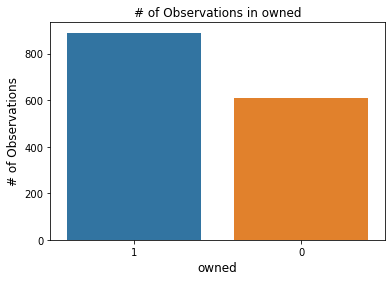

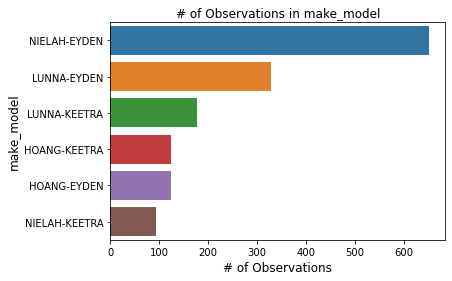

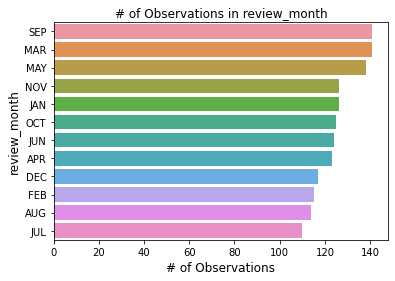

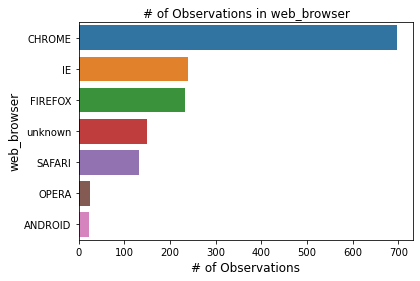

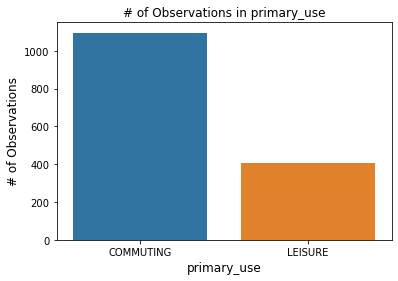

In [42]:
# Single Variable

# Categorical
for col_name in data.select_dtypes(exclude="number").columns:
    nunique = data[col_name].nunique()
    desc_order = data[col_name].value_counts().index
    if nunique > 5 and nunique < 20:
        sns.countplot(data=data, y=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.xlabel("# of Observations")
        plt.ylabel(col_name)
        plt.show()
    elif nunique <= 5:
        sns.countplot(data=data, x=col_name, order=desc_order)
        plt.title(f"# of Observations in {col_name}")
        plt.ylabel("# of Observations")
        plt.xlabel(col_name)
        plt.show()
    else:
        print(f"🚨 {col_name} column had 20 or more unique values, so distribution skipped. Consider binning this variable 🚨")

**The majority of reviews were given by moped owners as opposed to non-owners *(~60% owners)*. The split is balanced enough to not have to worry about class imbalance.**

The most reviewed `make_model` is by far the `NIELAH-EYDEN`, but the other classes have ~ 100+ observations.

`month_reviewed` is fairly evenly distributed with the most reviews being made in `Sep`

Almost half of the reviews were made through the Google Chrome web browser, 150 of reviews had a `NULL` value for `web_browser` that we encoded as `unknown`.

We may need to stratify on `web_browser` when splitting the data into train and test sets so that we guarantee the `Andriod` and `Opera` classes are in both the train and test sets
* If we didn't do this, then we might need to specify how to handle and unknown class when using the model to predict.
* Alernately, we could bucket the `Andriod` and `Opera` classes into a single `Other` class.

Finally, two-thirds of the reviewers use their car for commuting as opposed to leisure.

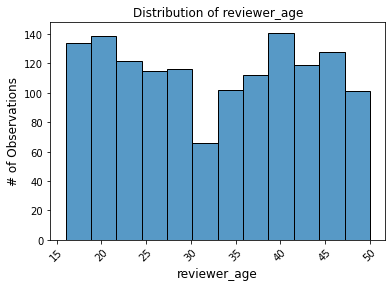

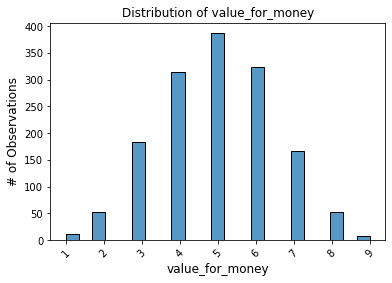

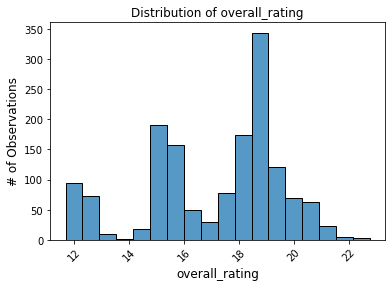

In [43]:
# Distributions - Histogram, KDE, ECDF
# Categorical - Count plots, boxplots, violinplot
### Mixutre of single variable plots, 2+ variable plots for Distributions and Categorical
# Relational - Pair plots / scatter plots, line plots, boxplots. Try 2 variable combinations, and add a hue for 3rd variable to see interaction relationship

# Set axis label sizes to slightly larger than default
plt.rcParams["axes.labelsize"] = 12

# Single Variable 

# Distributions
for col_name in data.select_dtypes(include="number").columns:
    sns.histplot(data=data, x=col_name)
    plt.title(f"Distribution of {col_name}")
    plt.xticks(rotation=45)
    plt.ylabel("# of Observations")
    plt.show()

`reviewer_age` looks close to a uniform distribution, `value_for_money` is normally distributed, and **`overall_rating` appear multi modal.**

**There are no extremely low or high values for `overall_rating`, with peaks at 15 and 19. Most of the reviews have a decently high `overall_rating`.**

There does not appear to be any glaring outliers in these variables.

We could explore the effects of binning the `reviewer_age` variable to capture some demographic related information.

We likely will want to scale our data before fitting our model.

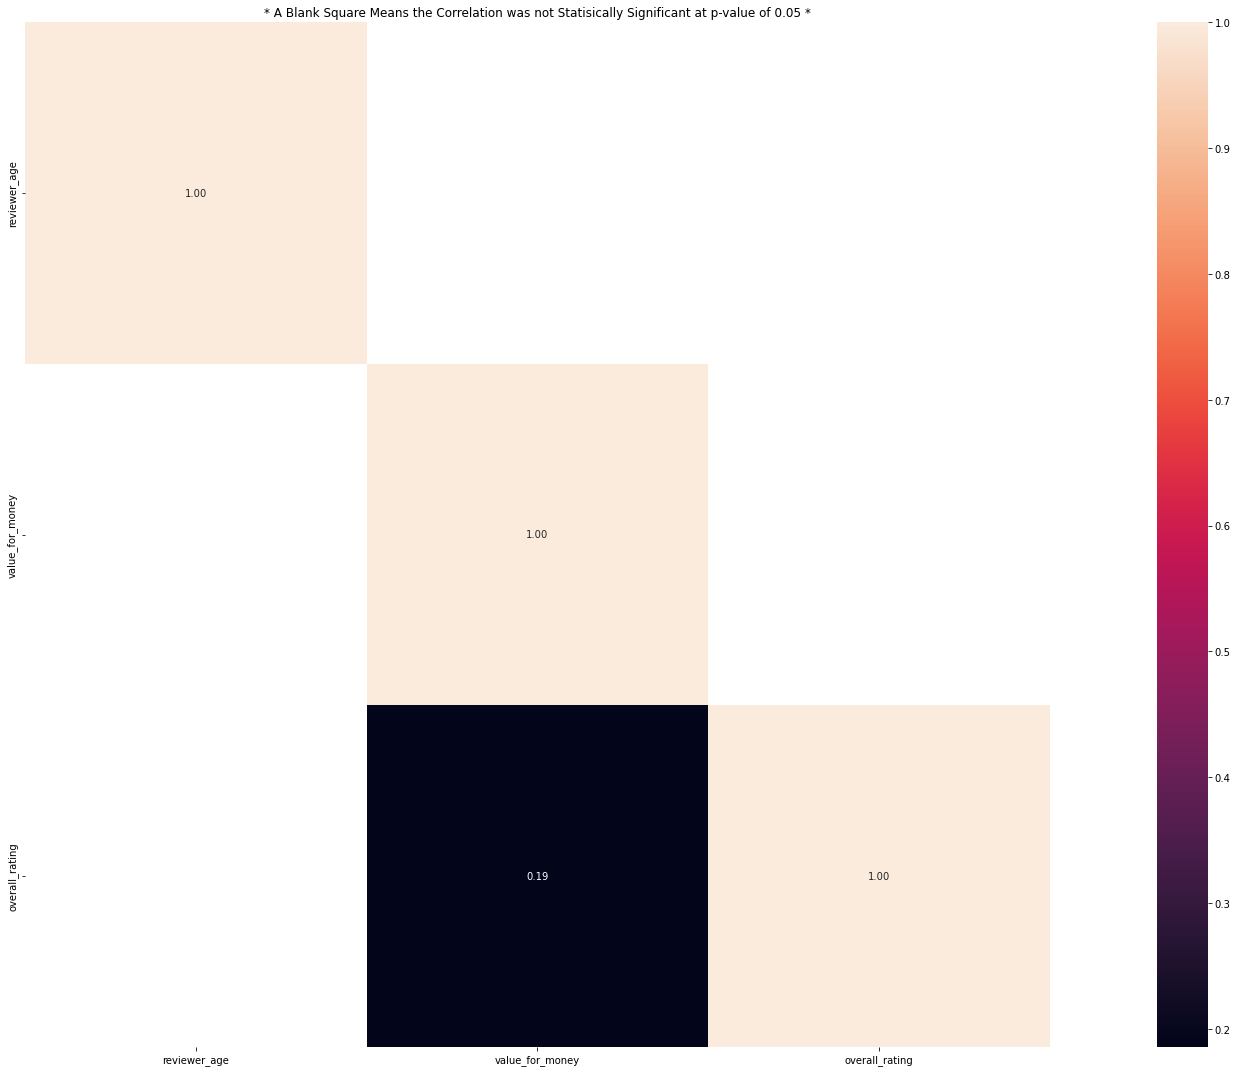

In [44]:
# Pearson's r Correlation Heatmap
# Correlation Matrix

# Code to "mask" correlations that are not statistically significant from heatmap
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = scipy.stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix

p_values = corr_sig(data.select_dtypes('number').dropna())
mask = np.invert(np.tril(p_values<0.05))

# Set up the matplotlib figure
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(30, 15))

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(data.corr(method="pearson"),
                       mask=mask,
                       annot=True,
                       fmt='.2f',
                       square=True)
g.set(title="* A Blank Square Means the Correlation was not Statisically Significant at p-value of 0.05 *")
f.set_tight_layout(True)

The only significant pearson correlation among the numeric predictors is a weak positive correlation between `value_for_money` and `overall_rating`

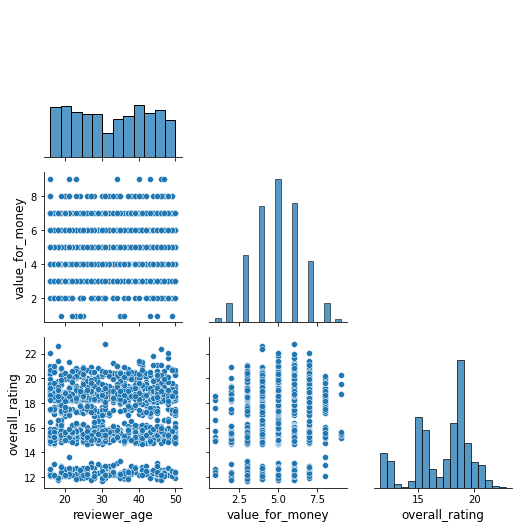

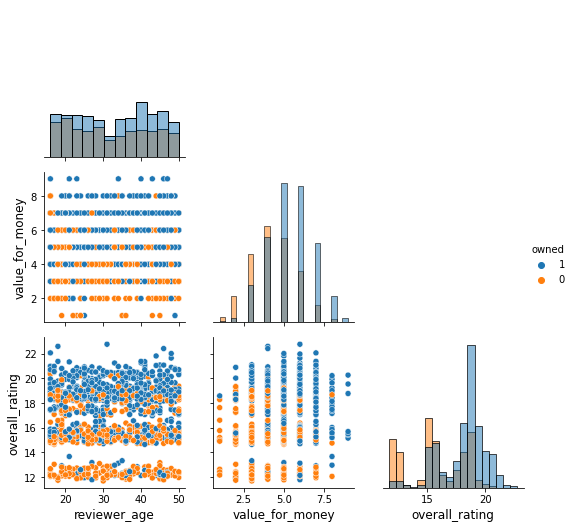

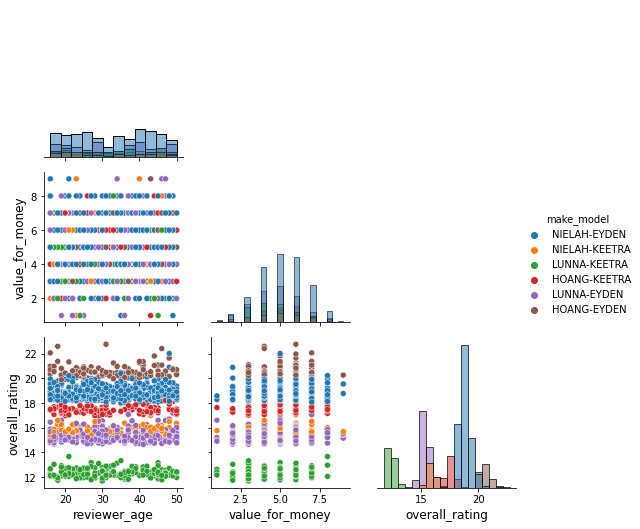

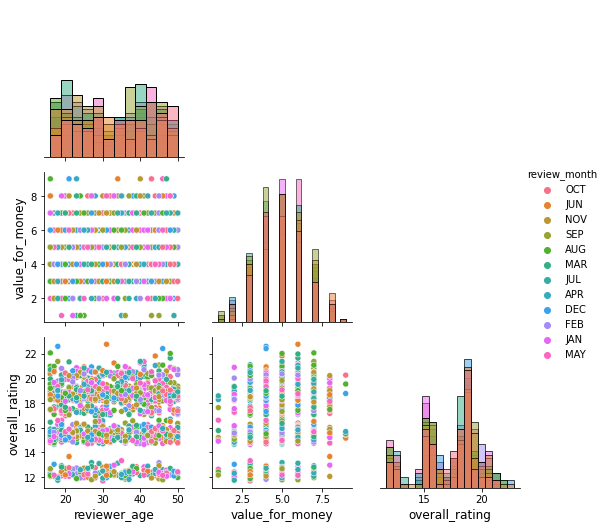

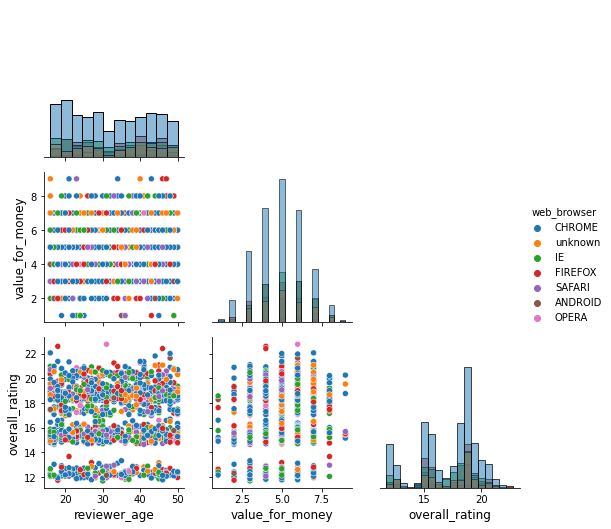

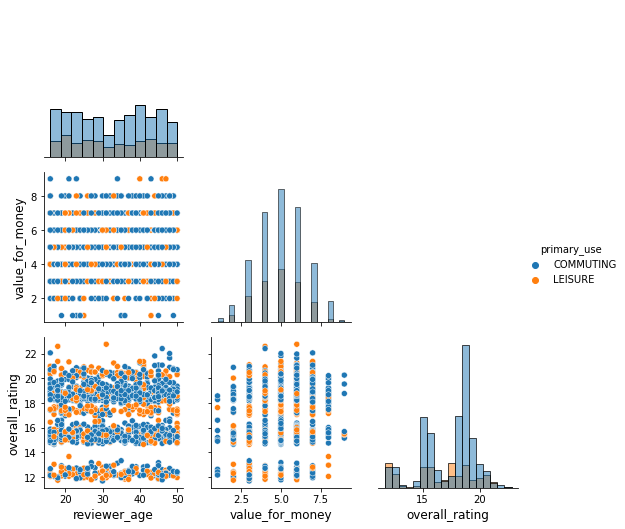

In [45]:
# Multiple Variables

# Relational

# No hue
g = sns.PairGrid(data, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

# With hue for each categorical variable
for col_name in data.select_dtypes(exclude="number").columns:
    g = sns.PairGrid(data, corner=True, hue=col_name)
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()
    plt.show()

**From the second pairplot (colored by `owned`), we can see that owners tend to leave reviews with a higher `overall_rating`, and a higher `value_for_money`, than non owners.**

There is a significant relationship between `make_model` and `overall_rating` as seen in the third pairplot (colored by `make_model`). The `make_model`'s with the highest to lowest `overall_rating` are
* `HOANG-EYDEN`
* `NIELAH-EYDEN`
* `HOANG-KEETRA`
* `NIELAH-KEETRA`
* `LUNNA-EYDEN`
* `LUNNA-KEETRA`

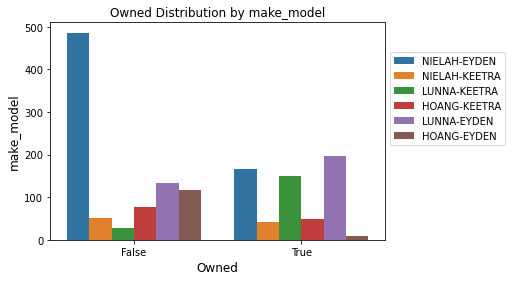

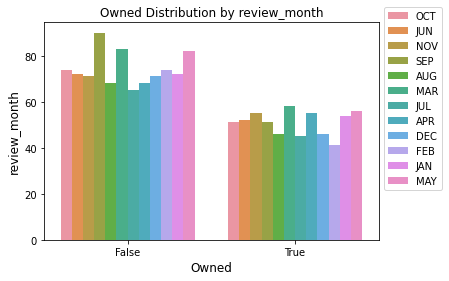

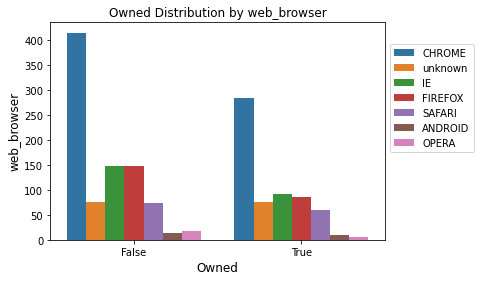

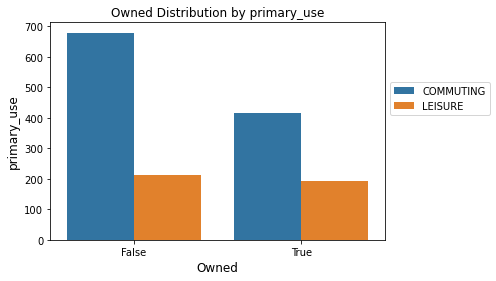

In [46]:
# Multiple Variables
# Replace with target column name
target = "owned"
for col_name in data.drop(columns=target).select_dtypes(exclude="number").columns:
    g = sns.countplot(data=data, x=target, hue=col_name)
    g.set(xlabel="Owned", ylabel=col_name, xticklabels=[False, True])
    g.set_title(f"Owned Distribution by {col_name}")
    g.legend(loc='center left', bbox_to_anchor=(1, .65), ncol=1)
    plt.show()

Owners gave the majority of the reviews on the `HOANG-EYDEN` `make_model`, whereas Non-Owners gave the majority of the reivews on the `LUNNA-KEETRA` `make_model`. The rest of the models are fairly evenly reviewed between Owners and Non-Owners.

A note worth exploring about on the relationship between `make_model`, `overall_rating`, and `owned`:
* Is the `HOANG-EYDEN` `make_model` a better moped (higher `overall_rating`) and therefore more likely to be owned ?
	* Similarly, is the `LUNNA-KEETRA` `make_model` a worse moped (lower `overall_rating`) and therefore less likely to be owned ?
* Are Owners biased in their reviews / tend to give higher `overall_ratings` in general ? 
	* Could there be another reason why `HOANG-EYDEN` has more Owner reviews ?

The distributions for `review_month`, `web_broswer`, and `primary_use` are very similar across owners and non-owners.

Let's test the hypothesis that Owners tend to give higher values for `overall_rating` compared to Non-Owners by comparing the distribution of `overall_rating` for the same `make_model` across Owners vs Non-Owners

<AxesSubplot:xlabel='overall_rating', ylabel='make_model'>

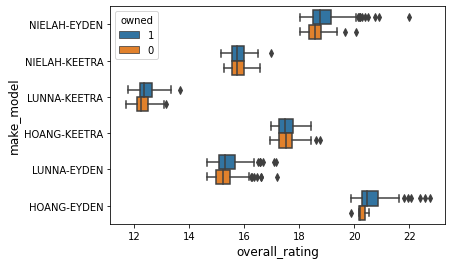

In [47]:
sns.boxplot(data=data, y="make_model", x="overall_rating", hue="owned")

It does not seem that Owners give noticeably higher values for `overall_rating` than Non-Owners for the same `make_model`.

This supports the hypothesis that certain `make_model`'s may be higher quality and are therefore more likely to be owned.

Let's continue on by looking at the relationship between `owned` and 2 way combinations of predictors

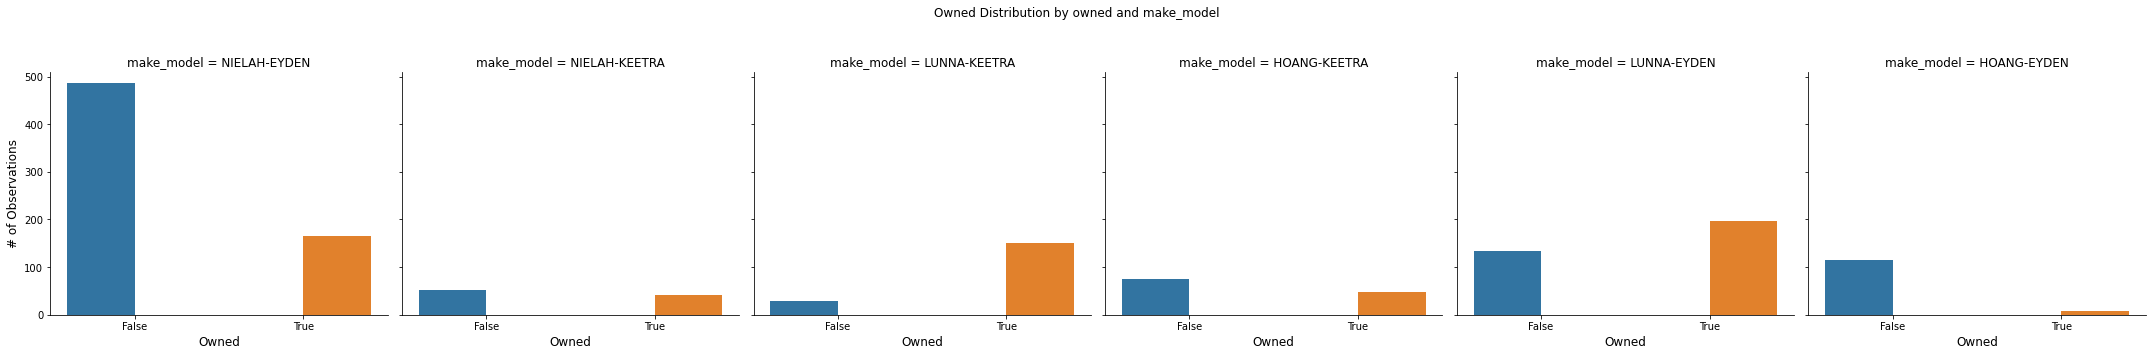

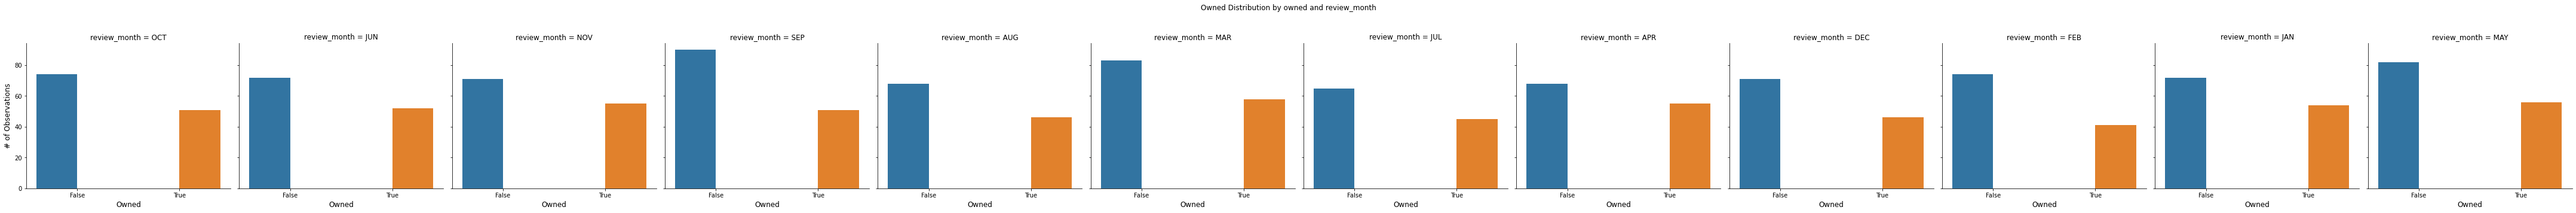

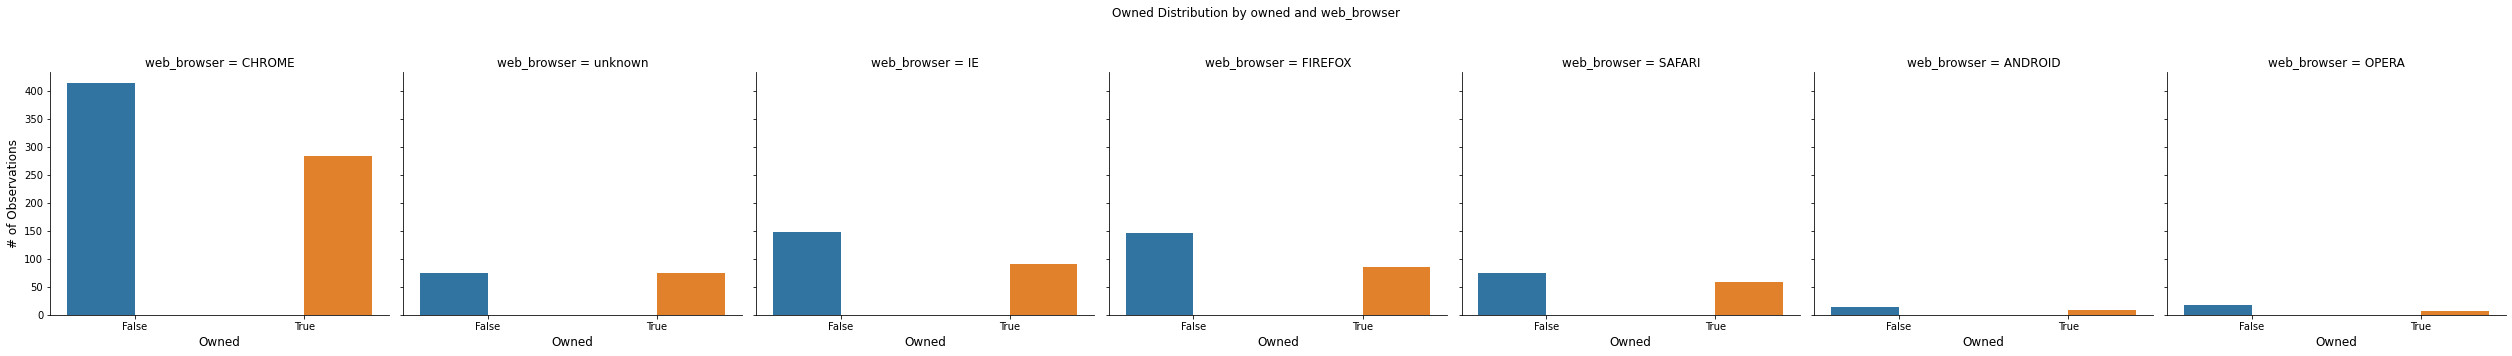

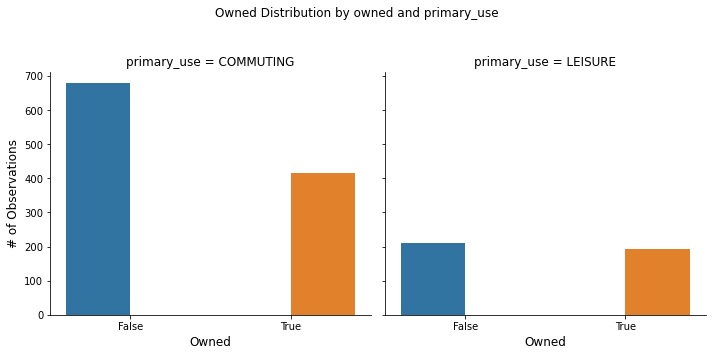

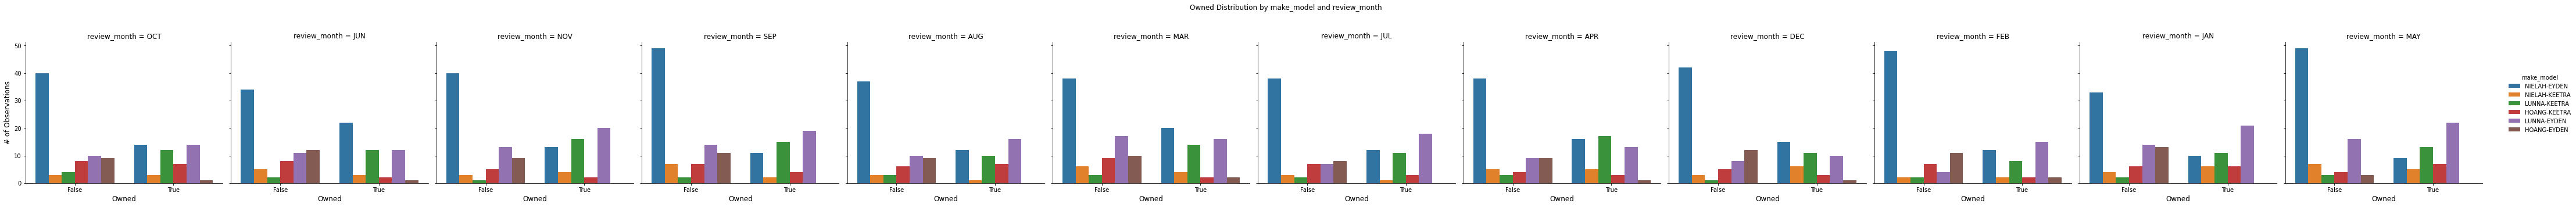

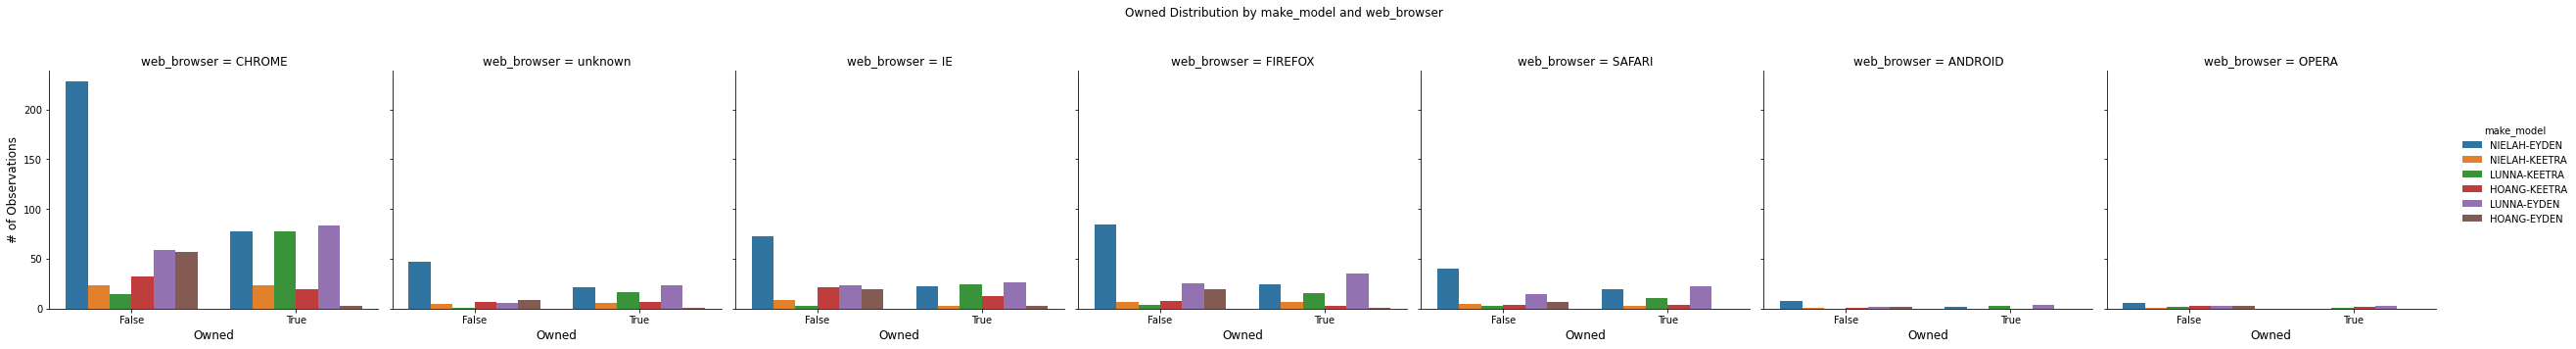

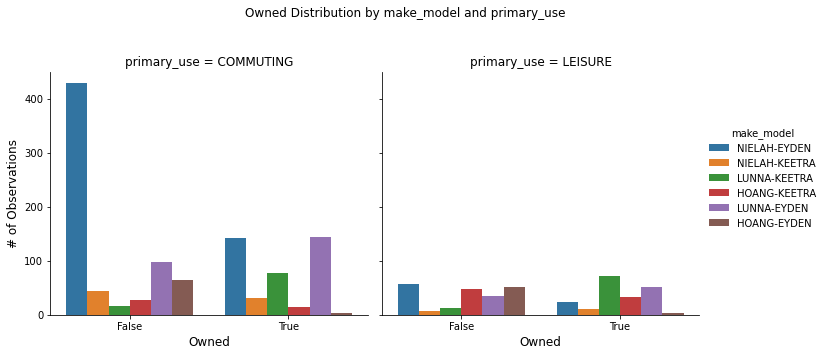

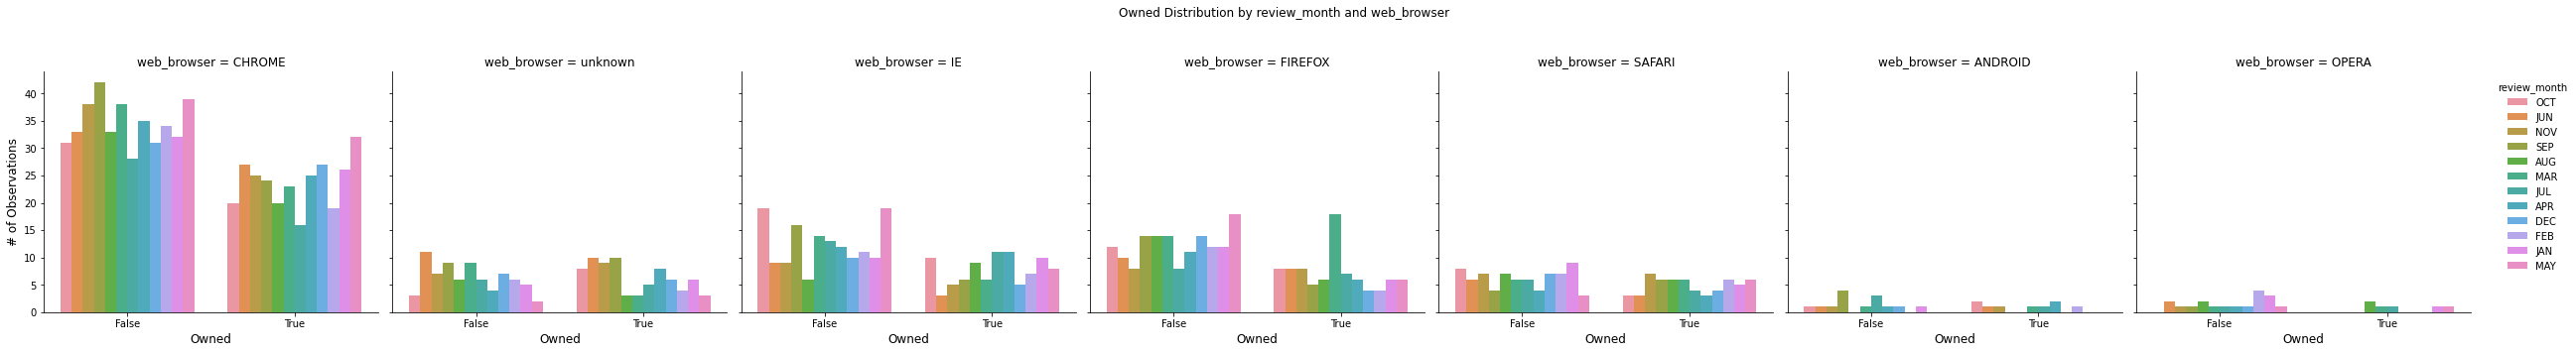

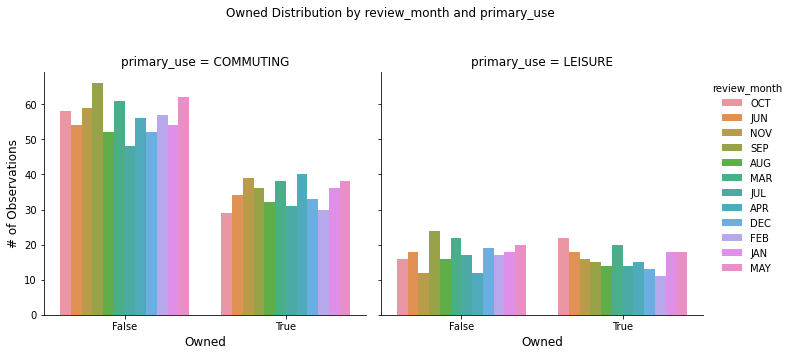

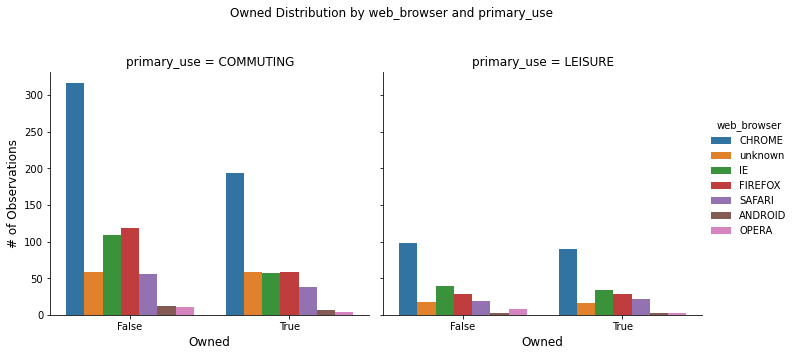

In [48]:
L = data.select_dtypes(exclude="number").columns
# All unqiue 2 way combinations
unique_2_way_combos = [comb for comb in combinations(L, 2)]
for i, j in unique_2_way_combos:
    g = sns.catplot(data=data, x=target, hue=i, col=j, kind="count")
    g.set_axis_labels("Owned", "# of Observations")
    g.set_xticklabels([False, True])
    g.set_titles("{col_var} = {col_name}")
    g.fig.subplots_adjust(top=0.8)
    g.fig.suptitle(f"Owned Distribution by {i} and {j}")
    plt.show()

We see another interesting interaction between `make_model` and `primary_use` -- some models are used a lot nore for commuting purposes compared to leisure purposes.

The `NIELAH-EYDEN` model is used mainly as a commuter vehicle, whereas the `HOANG-EYDEN` model is commonly used for leisure. This could be because the `NIELAH-EYDEN` is an economic model and the `HOANG-EYDEN` model is more of a "luxury" model.

Another thing to explore is the separation of make and model into their own columns. It could be that certain makes or models are more likely to be owned. 

Let's plot this relationship

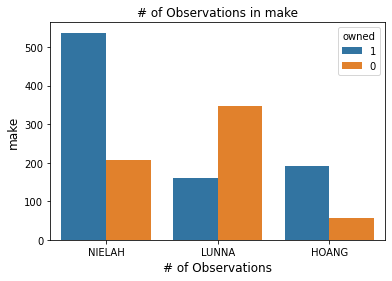

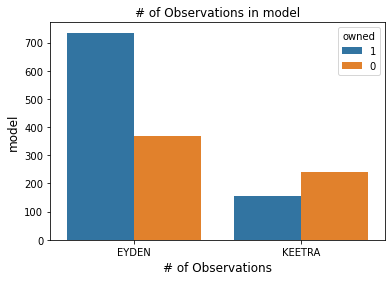

In [49]:
make_model_split = data["make_model"].str.split("-", expand=True)
make_model_split.columns = ["make", "model"]
data["make"] = make_model_split["make"]
data["model"] = make_model_split["model"]
for col_name in ["make", "model"]:
    sns.countplot(data=data, x=col_name, hue="owned")
    plt.title(f"# of Observations in {col_name}")
    plt.xlabel("# of Observations")
    plt.ylabel(col_name)
    plt.show()

# Remove columns for now
data.drop(columns=["make", "model"], inplace=True)

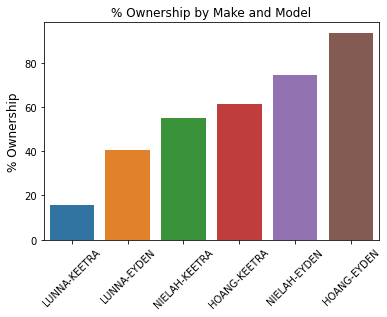

In [50]:
pct_ownership_by_make_model = data[data["owned"] == '1']["make_model"].value_counts() / data["make_model"].value_counts()
pct_ownership_by_make_model.sort_values(inplace=True)
sns.barplot(x=pct_ownership_by_make_model.index.values, y=pct_ownership_by_make_model * 100)
plt.title(f"% Ownership by Make and Model")
plt.xticks(rotation=45)
plt.ylabel("% Ownership")
plt.show()

interval columns not set, guessing: ['reviewer_age', 'value_for_money', 'overall_rating']
interval columns not set, guessing: ['reviewer_age', 'value_for_money', 'overall_rating']


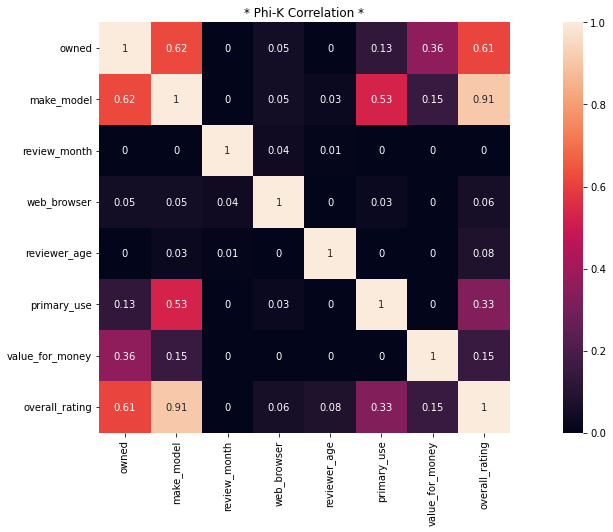

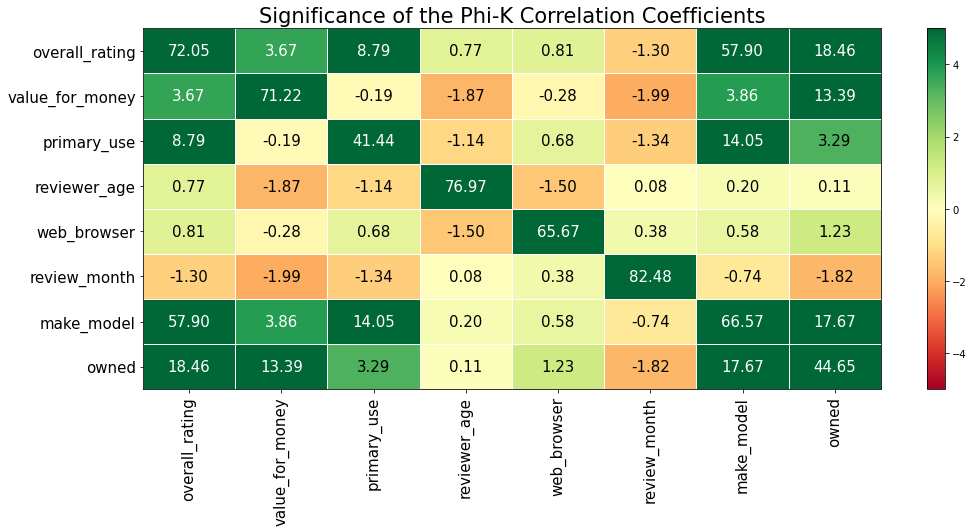

In [51]:
# Phi-k Correlations (Categorical and Numeric combined)
f, ax = plt.subplots(figsize=(15, 7.5))
g = sns.heatmap(data=data.phik_matrix().round(2), annot=True, square=True)
g.set(title="* Phi-K Correlation *")
f.set_tight_layout(True)

# Phi-k Correlation Coefficient Significance
significance_overview = data.significance_matrix()
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the Phi-K Correlation Coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(15, 7.5))
plt.tight_layout()

The 3 highest correlations with `owned` in descending order are:
1. `make_model`
2. `overall_rating`
3. `value_for_money`

We can see they are all statistically significant from the significance heat map.

We need to be aware that `make_model` and `overall_rating` are highly correlated, and can throw off the interpretation of our model coefficients when using a linear model like logistic regression.
* This effect is called [Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)
*This does not have an impact on the predicitve power of the model, only the interpretability*

## Objective Revisited 

This is a **classification problem** since we are predicting whether a review was from an owner or non-owner. 

Classification tasks are an example of *supervised machine learning problem* since we are training our model on known labels *(owner or non-owner here)*.

## Baseline Model
---

Now that we have explored our data and the relationships of with predictors with `owned`, we can start fitting models and evaluating them.

To assess whether our fitted model is actually helping us or not, we can "train" and score 2 baseline models to compare our final selection to.

The baselines will consist of:
1. A simple classifier that predicts the mode value of `owned` each time
2. An untuned and less complex machine learning model like K-NN

The model we present the business and choose to deploy needs to better than the mode classifier at least as good as the untuned K-NN model.

In [52]:
# Either use a simple model like Logistic Regression or just the mode value. You should be able to do better than this
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Train Test Split
X = data.drop(columns=target)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Mode Baseline
mode_y = data[target].mode()
print(f"Mode value of the target = {mode_y.iloc[0]}")
y_pred = [mode_y] * len(y_test)
print(f"Baseline Model Test Accuracy (using mode as the predicted value) = {accuracy_score(y_test, y_pred):,.3f}")

Mode value of the target = 1
Baseline Model Test Accuracy (using mode as the predicted value) = 0.595


In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Convert owned back to int
data["owned"] = data["owned"].astype(int)

# Train Test Split
X = data.drop(columns=target)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

# Define different Pipelines for Numeric vs. Categorical

# Mean imputation for numeric variables (including reviewer_age which we were instructed to do)
numeric_transformer = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="mean"))
        ]
)

# Mode imputation for categorical variables although none have missing values here
categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent")), 
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

numeric_features = X_train.select_dtypes(include="number").columns.values
categorical_features = X_train.select_dtypes(exclude="number").columns.values

# Combine into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ]
)


# Define a single Pipeline with all of the steps
steps = [
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ]
pipeline = Pipeline(steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"K-NN Model Test Accuracy = {accuracy_score(y_test, y_pred):,.3f}")

K-NN Model Test Accuracy = 0.717


Our first baseline model simply used the **mode value for all of its predictions** and acheived a 59% accuracy. 

Our other baseline model was a K-NN model and acheived a 71.7% accuracy *(with no feature engineering or numeric scaling)*.

We need our model to be at least better than the simple mode baseline model's accuracy, and ideally better than the K-NN model accuracy.

To make a more accurate model we can:
1. Perform feature engineering
2. Tune the hyperparameters of our selected model

## Feature Engineering
---

We can extract more information about our problem by creating new features to test hypothesis.

We will test the following:
* Do mopeds with a high `value_for_money` and high `overall_rating` have more reviews from Owners ?
	* Create a variable that combines the `value_for_money` and `overall_rating` variables to test this
* Create a boolean column `is_HOANG_EYDEN` that is `true` if `make_model` is `HOANG-EYDEN` and `false` if any other model

In [54]:
# Create new features here

# Ratio of value_for_money and overall_rating
data["value_to_rating_ratio"] = data["overall_rating"] / data["value_for_money"]

# Binning of various features
data["is_HOANG_EYDEN"] = ["true" if val == "HOANG-EYDEN" else "false" for val in data["make_model"]]

**Note:** Based on intuition gained from our EDA as well as experimentation with interaction terms and various combinations of predictors, I found the maximum cross validation accuracy via these 4 predictors:

1. `overall_rating`
2. `value_for_money`
3. `value_to_rating_ratio`
4. `is_HOANG_EYDEN`

I found that removing some of the "noisy" predictors lead to an improved cross validation accuracy.

Additionally, a model with less features is less complex, easier to understand, and faster to retrain.

*For more details and reproducible code on experiments tried, please check out the [Appendix](#Appendix)*

## Model Fitting, Evaluation, and Selection

In [55]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Split the data
# X = data.drop(columns=[target])
### Models do better with only these 4 variables
X = data[["overall_rating", "value_for_money", "value_to_rating_ratio", "is_HOANG_EYDEN"]]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


# Define different Pipelines for Numeric vs. Categorical
numeric_transformer = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="mean")), 
        ("scaler", MaxAbsScaler())
        ]
)

categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent")), 
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

numeric_features = X_train.select_dtypes(include="number").columns.values
categorical_features = X_train.select_dtypes(exclude="number").columns.values

# Combine into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features)
    ]
)


# Define a single Pipeline with all of the steps
### Try different models and select the one with the best cross_val_score
models = [DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier(), SVC()]
cv_accuracys = []
pipelines = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', model)
    ]
    pipeline = Pipeline(steps)
    pipelines.append(pipeline)
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=4, scoring='accuracy').mean()
    print(f'''{str(model).split("(")[0]} Cross Validation Accuracy\n{cv_accuracy:,.3f}''')
    cv_accuracys.append(cv_accuracy)

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


DecisionTreeClassifier Cross Validation Accuracy
0.680
LogisticRegression Cross Validation Accuracy
0.762
KNeighborsClassifier Cross Validation Accuracy
0.718
RandomForestClassifier Cross Validation Accuracy
0.691
[14:40:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:40:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier Cross Validation Accuracy
0.718
SVC Cross Validation Accuracy
0.756


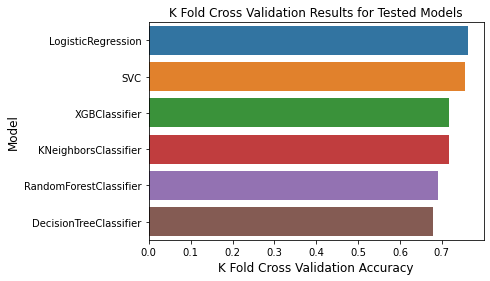

,model,cross_validation_accuracy,pipeline
1,LogisticRegression,0.761761,(ColumnTransformer(transformers=[('categorical...
5,SVC,0.755546,(ColumnTransformer(transformers=[('categorical...
4,XGBClassifier,0.718218,(ColumnTransformer(transformers=[('categorical...
2,KNeighborsClassifier,0.718214,(ColumnTransformer(transformers=[('categorical...
3,RandomForestClassifier,0.690669,(ColumnTransformer(transformers=[('categorical...
0,DecisionTreeClassifier,0.679999,(ColumnTransformer(transformers=[('categorical...


Maximum cross validation Accuracy (0.762) acheived with LogisticRegression model


In [56]:
# Display the cross validation results for various models tested
cv_results = pd.DataFrame({
    "model": [str(model).split("(")[0] for model in models],
    "cross_validation_accuracy": cv_accuracys,
    "pipeline": pipelines
}).sort_values(by="cross_validation_accuracy", ascending=False)
sns.barplot(data=cv_results, y="model", x="cross_validation_accuracy")
plt.title("K Fold Cross Validation Results for Tested Models")
plt.xlabel("K Fold Cross Validation Accuracy")
plt.ylabel("Model")
plt.show()
display(cv_results)
best_model = cv_results.loc[cv_results['cross_validation_accuracy'].idxmax()]['model']
print(f"Maximum cross validation Accuracy ({max(cv_results['cross_validation_accuracy']):,.3f}) acheived with {best_model} model")

We achieved the highest cross validation accuracy (76.2%) with the logistic regression model, so expect this model to be the most accurate for future predictions.

Cross validation lets us estimate how well our models will perform on the future data (like our Test set), thus we will proceed with the model that yields the highest cross validation accuracy.

The logistic regression model yielded the highest cross validation accuracy, so will use it as our final model and proceed to tuning.

## Hyperparameter Tuning the Selected Model
---

In [57]:
# List the model parameters so we can tune them
cv_results.loc[cv_results['cross_validation_accuracy'].idxmax()]['pipeline']["classifier"].get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [58]:
# Score the model before tuning parameters
best_untuned_model_pipeline = cv_results.loc[cv_results['cross_validation_accuracy'].idxmax()]['pipeline']
best_untuned_model_pipeline.fit(X_train, y_train)
untuned_accuracy = best_untuned_model_pipeline.score(X_test, y_test)

# Model Tuning
steps = [
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]
pipeline = Pipeline(steps)

# Set up the parameter grid to search over
param_grid = {
    "preprocessor__numeric__scaler": [MinMaxScaler(), StandardScaler(), MaxAbsScaler(), 'passthrough'],
    "classifier__solver": ['newton-cg', 'lbfgs', 'liblinear'],
    "classifier__penalty": ['l1', 'l2', 'elasticnet'],
    "classifier__C": [100, 10, 1.0, 0.1, 0.01],
    "classifier__fit_intercept": [False, True]
}

cv = GridSearchCV(pipeline
                  , cv = 4
                  , param_grid=param_grid
                 , scoring='accuracy'
                 , return_train_score=True)

cv.fit(X_train, y_train)

# Final Test of Tuned model
y_pred = cv.predict(X_test)
tuned_accuracy = accuracy_score(y_pred, y_test)


# Print Results
print(f"Untuned CV Accuracy\n{max(cv_results['cross_validation_accuracy']):0.3f}")
print(f"Tuned CV Accuracy\n{cv.best_score_:0.3f}")
print(f"Test Accuracy before Hyperparamter Tuning\n{untuned_accuracy:0.3f}")
print(f"Test Accuracy after Hyperparamter Tuning\n{tuned_accuracy:0.3f}")

Untuned CV Accuracy
0.762
Tuned CV Accuracy
0.764
Test Accuracy before Hyperparamter Tuning
0.725
Test Accuracy after Hyperparamter Tuning
0.739


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
800 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/natha

Tuning our model gave us a 0.2% increase in cross validation accuracy and lead to a 1.4% increase in test accuracy.

Let's examine the final machine learning pipeline we have built and the top 5 parameter selections

In [59]:
print(f"Tuned Model Best Params: {cv.best_params_}")
print("\n")
print(f"Final Machine Learning Pipeline")
display(cv.best_estimator_)
print("\n")
print(f"Top 5 Model Parameters and Stats (Based on Mean CV Test Accuracy)")
top_models_df = pd.DataFrame(cv.cv_results_).sort_values(by="mean_test_score", ascending=False)[["rank_test_score", "params", "mean_test_score", "mean_train_score"]].head(5)
display(top_models_df)

Tuned Model Best Params: {'classifier__C': 0.1, 'classifier__fit_intercept': False, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'preprocessor__numeric__scaler': StandardScaler()}


Final Machine Learning Pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  array(['is_HOANG_EYDEN'], dtype=object)),
                                                 ('numeric',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                              



Top 5 Model Parameters and Stats (Based on Mean CV Test Accuracy)


,rank_test_score,params,mean_test_score,mean_train_score
225,1,"{'classifier__C': 0.1, 'classifier__fit_interc...",0.764443,0.761480
189,2,"{'classifier__C': 1.0, 'classifier__fit_interc...",0.763544,0.761775
261,2,"{'classifier__C': 0.1, 'classifier__fit_interc...",0.763544,0.761183
237,4,"{'classifier__C': 0.1, 'classifier__fit_interc...",0.763541,0.762665
229,4,"{'classifier__C': 0.1, 'classifier__fit_interc...",0.763541,0.762665


## Baseline Model Comparison

We achieved a 14.38% increase in overall accuracy relative to the simple mode value, and a 2.2% increase in overall accuracy relative to the `K-NN` baseline model by selecting and tuning our `Logistic Regression` model.

Our tuned model is much more accurate than our simple `mode` baseline model, and slightly more accurate than our `K-NN` baseline model.

## Results

Our tuned model had a 4-Fold CV accuracy of ~76.5% which was higher than our untuned model's 4-Fold CV accuracy of ~75.5%.

Because the tuned model's CV results were better than the untuned model's CV results, we expect the tuned model to outperform the untuned model and hence, we will proceed with the tuned model.

The tuned `Logistic Regression` model achieved a 73.9% accuracy on our test data and is **our choice for deployment to production.**

Our conclusion is based on the assumption that accuracy is our criteria for the _best_ model. This is not always the case, as you could want to minimize the probability of producing a [false positive or false negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative).

***Think:** For our business, does the wrongly predicting an Owner as a Non-Owner negatively impact us more than wrongly predicting an Non-Owner as a Owner?*

*Maybe we want to send our reviewers some promotional content to keep them engaged or happy. We would care more about our model being able to correctly predict who is an Owner, so that we maximize the number of current customers who recieve the gift. In this case our criteria for the best model would be the true positive rate instead of accuracy*

Let's examine the results of our model's predictions a bit more closely.

### Confusion Matrix

We can break down our model's accuracy further by examining the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

The confusion matrix shows us the number of predictions that were:
- true positive $(TP)$
- true negative $(TN)$
- false positive $(FP)$
- false negative $(FN)$

From this we can derive summary statistics:

**Accuracy** $\implies \frac{TP + TN}{TP + TN + FP + FN}$

**Precision** $\implies \frac{TP}{TP + FP}$

**Recall** $\implies \frac{TP}{TP + FN}$

**F1 Score** $\implies \frac{2 * \text{precision} * \text{recall}}{\text{precision} + \text{recall}}$

In [60]:
def plot_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    percent:       If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    prediction_types = ['True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)', 'True Positive (TP)']
    
    box_labels = [f"{v1}{v2}{v3}\n\n{v4}".strip() for v1, v2, v3, v4 in zip(group_labels,group_counts,group_percentages,prediction_types)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

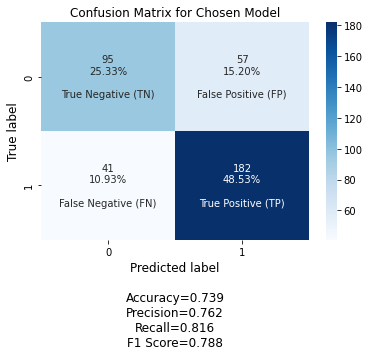

In [61]:
cf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cf_matrix, title="Confusion Matrix for Chosen Model")

## Business Recommendations

_(Bonus)_

#### KPIs to track over time
* We should track the accuracy of the model over time
	* If it starts to decline, we should come back to our analysis and rebuild
* We should keep track of the metrics from the confusion matrix to see if there is a drift in one of the false positive or false negative proportions

#### How to deploy the model
* We could host the model on a cloud provider (hosted endpoint via SageMaker on AWS, or similar)
* We could self host the model and build an API with FastAPI

#### Updating the model
* Use the UI from the cloud provider or set up a CI/CD process for kicking off a retraining job.
* Set up a CI/CD process for our FastAPI application (Get help from the infrastructure department)

#### Next steps for model improvement
* We can come up with more predictors to collect at the source
	* More granular time series data
	* More user related data -- phone type, sentiment of the review, demographic data, etc.
* We should continue to collect the source data and rebuild models as we can more training data.
* Keep exploring relationships between `owned` and predictors for more understanding and intuition


## Appendix
---
*Supplemental work that did not fit into the flow of the report. This is the place for demonstrating things tested, but did not necessarily help our models accuracy*

A stratified train test split on `web_browser` lowered cross validation accuracy, so did not stratify during our split.
```
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=X["web_browser"])
```

Binning the OPERA and ANDROID the `web_browser` columns did not increase cross validation accuracy
```
# Combine less common web browsers into single category
data["web_browser"] = ["OTHER" if value == "OPERA" or value == "ANDROID" else value for value in data["web_browser"]]
```

Binning the `overall_rating` did not improve cross validation accuracy. Nor did separating `make_model` into 2 columns -- `make` and `model`

```
data["rating_category"] = pd.qcut(data["overall_rating"], q=[0, .25, .5, .75, 1.], labels=["Low Rating", "Medium Rating", "High Rating", "Top Rating"])

# Separate Make and Model
make_model_split = data["make_model"].str.split("-", expand=True)
make_model_split.columns = ["make", "model"]
data["make"] = make_model_split["make"]
data["model"] = make_model_split["model"]
```

Creating interaction terms (with and without feature selection using `SelectKBest`) lowered cross validation accuracy, so we did not include interaction terms in our model

```
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier

# Split the data
X = data.drop(columns=target)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


# Define different Pipelines for Numeric vs. Categorical
numeric_transformer = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent")), 
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

numeric_features = X_train.select_dtypes(include="number").columns.values
categorical_features = X_train.select_dtypes(exclude="number").columns.values

# Combine into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features),
    ]
)


# Define a single Pipeline with all of the steps
### Try different models and select the one with the best cross_val_score
models = [DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier(), SVC()]
cv_accuracys = []
pipelines = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        ('interactions', PolynomialFeatures()),
        ('dim_red', SelectKBest(score_func=f_classif, k=300)),
        ('classifier', model)
    ]
    pipeline = Pipeline(steps)
    pipelines.append(pipeline)
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=4, scoring='accuracy').mean()
    print(f'''{str(model).split("(")[0]} Cross Validation Accuracy\n{cv_accuracy:,.3f}''')
    cv_accuracys.append(cv_accuracy)
```

Using `TruncatedSVD` in addition to `PolynomialFeatures` for dimensionality reduction did not improve our model's accuracy

```
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD

# Split the data
# X = data.drop(columns=[target])
### Models do better with only these 2 variables
X = data[["overall_rating", "value_for_money", "reviewer_age"]]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


# Define different Pipelines for Numeric vs. Categorical
numeric_transformer = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent")), 
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

numeric_features = X_train.select_dtypes(include="number").columns.values
categorical_features = X_train.select_dtypes(exclude="number").columns.values

# Combine into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features)
    ]
)


# Define a single Pipeline with all of the steps
### Try different models and select the one with the best cross_val_score
models = [DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier(), SVC()]
cv_accuracys = []
pipelines = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        ('dim_reduction', TruncatedSVD),
        ('classifier', model)
    ]
    pipeline = Pipeline(steps)
    pipelines.append(pipeline)
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=4, scoring='accuracy').mean()
    print(f'''{str(model).split("(")[0]} Cross Validation Accuracy\n{cv_accuracy:,.3f}''')
    cv_accuracys.append(cv_accuracy)
```

Experimenting with the number of features as a parameters for our model

In [62]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif

# Get the max number of features that model can use
processing_and_fe_steps = [
    ('preprocessor', preprocessor),
    ('interactions', PolynomialFeatures())
]
processing_and_fe_pipeline = Pipeline(processing_and_fe_steps)
n_features = processing_and_fe_pipeline.fit_transform(X_train).shape[1]

k_list = np.linspace(1, n_features, dtype="int")
test_accuracys = []
train_accuracys = []
for k in k_list:
    steps = [
        ('preprocessor', preprocessor),
        ('interactions', PolynomialFeatures()),
        ('dim_red', SelectKBest(score_func=f_classif, k=k)),
        ('classifier', LogisticRegression(C=1.0, fit_intercept=True, penalty='l2', solver='newton-cg'))
    ]
    # Fit the model and score it
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracys.append(test_accuracy)
    train_accuracys.append(train_accuracy)

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 7] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nathanjones/opt/anacond

Max Test Accuracy of 0.75 acheived with 3
Max Test Accuracy of 0.75 acheived with 3
Max Test Accuracy of 0.75 acheived with 3
Max Test Accuracy of 0.75 acheived with 4
Max Test Accuracy of 0.75 acheived with 4


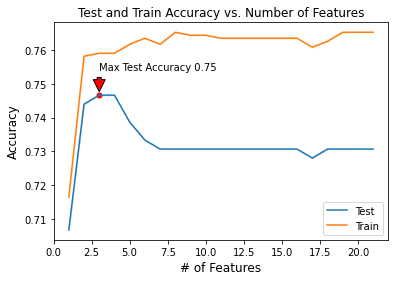

In [63]:
# Plot Accuracy for various # of features

# Test Accuracy
sns.lineplot(x=k_list, y=test_accuracys, label="Test")
test_maxima = []
for i in list(zip(k_list, test_accuracys)):
    if i[1] == max(test_accuracys):
        test_maxima.append(i)
plt.scatter(test_maxima[0][0], test_maxima[0][1], marker='o', c="red", s=25)
annotation_text_position = [test_maxima[0][0], test_maxima[0][1] * 1.01]
plt.annotate(f"Max Test Accuracy {test_maxima[0][1]:,.2f}", test_maxima[0], xytext=annotation_text_position, arrowprops={'facecolor':'red', "shrink":0.15})

for annotation_pt in test_maxima:
    print(f"Max Test Accuracy of {annotation_pt[1]:,.2f} acheived with {annotation_pt[0]}")

# Train Accuracy
sns.lineplot(x=k_list, y=train_accuracys, label="Train")
plt.title(f"Test and Train Accuracy vs. Number of Features")
plt.xlabel("# of Features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We omitted a Pandas Profiling EDA Report. This is a very nice and fast way to get a lot EDA done at once, but I wanted to demonstrate my knowledge by creating my own EDA.

It also does not create the more complex graphical EDA we used in our report.

```
# Create pandas_profiling EDA Report
profile = ProfileReport(data, title="Pandas Profiling Report")
# Display pandas_profiling EDA Report
profile.to_notebook_iframe()
```

Creating a `review_season` column from the `review_month` column did not improve accuracy and didn't have a meaningful relationship with `owned`

```
seasons_dict = {
    "Winter": ["DEC", "JAN", "FEB"],
    "Spring": ["MAR", "APR", "MAY"],
    "Summer": ["JUN", "JUL", "AUG"],
    "Fall": ["SEP", "OCT", "NOV"]
}
data["review_season"] = data["review_month"].map({item: k for k, v in seasons_dict.items() for item in v})
g = sns.countplot(data=data, x=target, hue="review_season")
g.set(xlabel="Owned", ylabel="review_season", xticklabels=[False, True])
g.set_title(f"Owned Distribution by review_season")
g.legend(loc='center left', bbox_to_anchor=(1, .65), ncol=1)
plt.show()
```

Experimentation with engineering interaction terms and polynomial terms via `PolynomialFeatures` lead to a decreased accuracy.

Feature selection using `SelectKBest` with an `f_classif` criteria helped when `k` was small suggesting that there are noisy predictors that are causing our accuracy to be lower.

```
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD

# Split the data
# X = data.drop(columns=[target])
### Models do better with only these 2 variables
X = data[["overall_rating", "value_for_money", "reviewer_age"]]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


# Define different Pipelines for Numeric vs. Categorical
numeric_transformer = Pipeline(
    steps=[
        ("numeric_imputer", SimpleImputer(strategy="mean")), 
        ("scaler", StandardScaler())
        ]
)

categorical_transformer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent")), 
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]
)

numeric_features = X_train.select_dtypes(include="number").columns.values
categorical_features = X_train.select_dtypes(exclude="number").columns.values

# Combine into single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features)
    ]
)


# Define a single Pipeline with all of the steps
### Try different models and select the one with the best cross_val_score
models = [DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier(), SVC()]
cv_accuracys = []
pipelines = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        ('interactions', PolynomialFeatures()),
        ('dim_red', SelectKBest(score_func=f_regression, k=10)),
        ('classifier', model)
    ]
    pipeline = Pipeline(steps)
    pipelines.append(pipeline)
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=4, scoring='accuracy').mean()
    print(f'''{str(model).split("(")[0]} Cross Validation Accuracy\n{cv_accuracy:,.3f}''')
    cv_accuracys.append(cv_accuracy)
```